# TSNN examples

## Summary

- In narrow format, both lin reg and fully connected manage to capture a linear effect between features and target. A linear regression will always be better in this case since this is constrained to be exactly the function of the ground truth


In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys
sys.path.append('/Users/cyrilgarcia/notebooks/tsnn/')

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils
import torch.nn.functional as F
import math


plt.style.use('ggplot')

In [3]:
z = generators.Generator(1000, 100, 10)

In [4]:
%%time
z.generate_dataset(pct_zero_corr = 0.5,
                          split_conditional = 0.,
                          split_shift = 1.0,
                          split_seasonal = 0.,
                          low_corr=0.1, high_corr=0.2)

CPU times: user 443 ms, sys: 35.1 ms, total: 478 ms
Wall time: 64.4 ms


In [5]:
z.get_dataloader()

### Simple benchmarks

In [6]:
# lasso benchmark
lasso = ml_benchmarks.LassoBenchmark()
lasso.fit(z.train)

In [7]:
lasso.score(z.train)

np.float64(0.009819222676647473)

In [8]:
# any custom benchmark
from sklearn.linear_model import LinearRegression
lr = ml_benchmarks.CustomBenchmark(LinearRegression())
lr.fit(z.train)

In [9]:
comp = benchmark_comparison.Comparator(models=[lasso, lr], model_names=['lasso', 'lr'])

In [11]:
comp.correl(z, mode='train')

,true,optimal,shift,lasso
optimal,0.2904,nan,nan,nan
shift,0.2904,1.0000,nan,nan
lasso,0.0098,-0.0076,-0.0076,nan
lr,0.0128,-0.0063,-0.0063,0.7664


In [12]:
comp.correl(z, mode='test')

,true,optimal,shift,lasso
optimal,0.2883,nan,nan,nan
shift,0.2883,1.0000,nan,nan
lasso,-0.0013,-0.0025,-0.0025,nan
lr,-0.0027,-0.0008,-0.0008,0.7634


## Torch benchmarks - narrow matrix (no cross-TS interactions)

### Fully connected

Equivalent to linear regression setup

In [13]:
z.get_dataloader(narrow=True)

In [14]:
from torch import nn
device = 'mps'

class NeuralNetwork(nn.Module):
    def __init__(self, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_f, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )
        
    def forward(self, x):
        pred = self.linear_relu_stack(x)
        return pred

In [15]:
m = NeuralNetwork(n_f=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.35it/s]


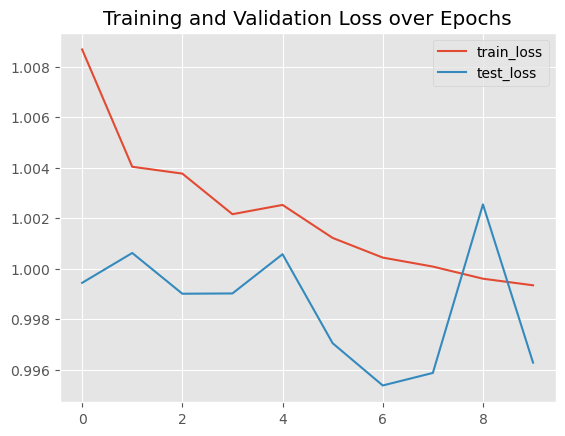

In [16]:
full_nn.fit(z.train, z.test, epochs=10)

In [17]:
comp = benchmark_comparison.Comparator(models=[full_nn, lasso], model_names=['nn', 'lasso'])

In [19]:
comp.correl(z, mode='train')

,true,optimal,shift,nn
optimal,0.2904,nan,nan,nan
shift,0.2904,1.0000,nan,nan
nn,0.0803,0.0199,0.0199,nan
lasso,0.0098,-0.0076,-0.0076,0.3079


In [20]:
comp.correl(z, mode='test')

,true,optimal,shift,nn
optimal,0.2883,nan,nan,nan
shift,0.2883,1.0000,nan,nan
nn,0.0085,0.0138,0.0138,nan
lasso,-0.0013,-0.0025,-0.0025,0.2959


### LSTM

Equivalent to linear regression setup

In [21]:
z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)

In [22]:
from torch import nn
device = 'mps'

class LSTMModel(nn.Module):
    def __init__(self, n_f, hidden_dim=32):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_f, hidden_size=hidden_dim, batch_first=True, num_layers=2)
        self.decoder = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # x: (batch, T=10, n_f)
        _, (h, _) = self.encoder(x)
        out = self.decoder(h[-1]) 
        return out

In [23]:
m = LSTMModel(n_f=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_lstm = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


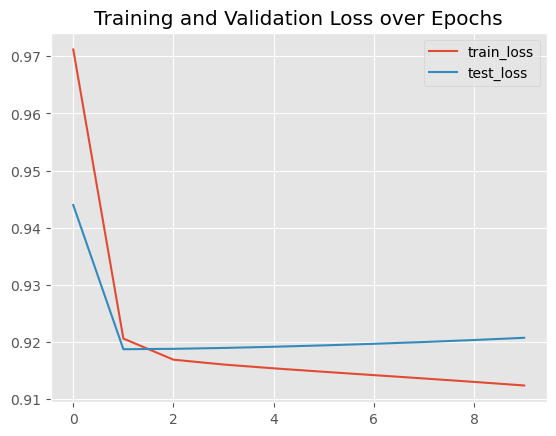

In [24]:
model_lstm.fit(z.train, test=z.test, epochs=10)

In [25]:
comp = benchmark_comparison.Comparator(models=[model_lstm, lasso], model_names=['lstm', 'lasso'])

In [26]:
comp.correl(z, mode='train')

,true,optimal,shift,lstm
optimal,0.2904,nan,nan,nan
shift,0.2904,1.0000,nan,nan
lstm,0.2999,0.9782,0.9782,nan
lasso,0.0094,-0.0037,-0.0037,0.0349


In [27]:
comp.correl(z, mode='test')

,true,optimal,shift,lstm
optimal,0.2882,nan,nan,nan
shift,0.2882,1.0000,nan,nan
lstm,0.2815,0.9778,0.9778,nan
lasso,-0.0002,-0.0114,-0.0114,0.0285


### Transformer

In [28]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_f, n_rolling, d_model=64, nhead=4, num_layers=1, dropout=0.1):
        super().__init__()
        self.input_dim = n_f
        self.d_model = d_model

        # Linear projection of n_f features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            # nn.LayerNorm(d_model),
            nn.Linear(d_model, 1)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_f)
        # print(x.shape)
        B, n_rolling, n_f = x.shape

        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, src_key_padding_mask=mask, mask=causal_mask)

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        
        # encoded = self.encoder(x, mask=causal_mask)#[: x.size(1), : x.size(1)])
        # out = self.decoder(encoded[:, -1, :]).squeeze(-1)
        # print(out.shape)
        # 1/0
        return out.reshape((-1, 1))

In [30]:
m = TransformerEncoderModel(10, 5).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:00<00:00,  3.03s/it]


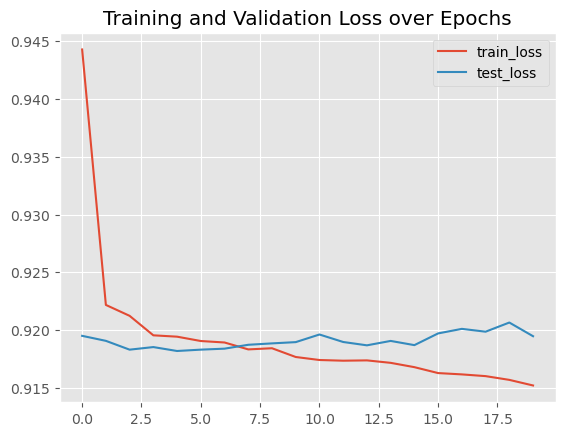

In [31]:
model_torch.fit(z.train, test=z.test, epochs=20)

In [32]:
comp = benchmark_comparison.Comparator(models=[model_torch, lasso], model_names=['transformer', 'lasso'])

In [33]:
comp.correl(z, mode='train')

,true,optimal,shift,transformer
optimal,0.2904,nan,nan,nan
shift,0.2904,1.0000,nan,nan
transformer,0.2993,0.9832,0.9832,nan
lasso,0.0094,-0.0037,-0.0037,0.0241


In [34]:
comp.correl(z, mode='test')

,true,optimal,shift,transformer
optimal,0.2882,nan,nan,nan
shift,0.2882,1.0000,nan,nan
transformer,0.2839,0.9839,0.9839,nan
lasso,-0.0002,-0.0114,-0.0114,0.0164


## Torch benchmarks - wide matrix (cross-TS interactions)

### Fully connected

In [35]:
z.get_dataloader()

In [36]:
from torch import nn
device = 'mps'

class NeuralNetwork(nn.Module):
    def __init__(self, n_ts, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_ts*n_f, 512),
            nn.ReLU(),
            # nn.Linear(512, 512),
            # nn.ReLU(),
            nn.Linear(512, n_ts),
        )
        
        self.linear_relu_stack = nn.Sequential(nn.Linear(n_ts*n_f, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_ts)
                                              )

    def forward(self, x):
        x = self.flatten(x)
        pred = self.linear_relu_stack(x)
        return pred

In [37]:
m = NeuralNetwork(n_ts=100, n_f=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-2)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.64it/s]


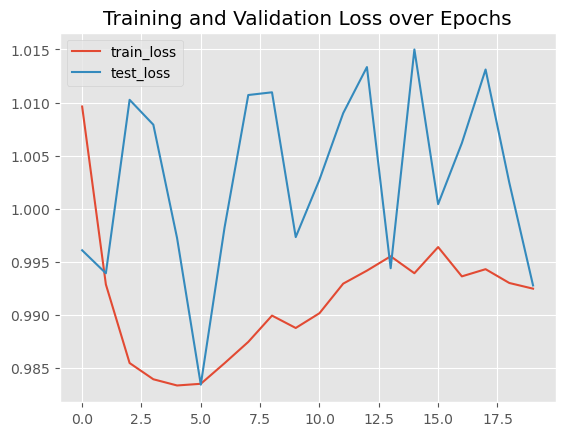

In [38]:
full_nn.fit(z.train, z.test, epochs=20)

In [39]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, full_nn], model_names=['lasso', 'lr', 'nn'])

In [40]:
comp.correl(z, mode='train')

,true,optimal,shift,lasso,lr
optimal,0.2904,nan,nan,nan,nan
shift,0.2904,1.0000,nan,nan,nan
lasso,0.0098,-0.0076,-0.0076,nan,nan
lr,0.0128,-0.0063,-0.0063,0.7664,nan
nn,0.1207,0.0361,0.0361,-0.0066,0.0006


In [41]:
comp.correl(z, mode='test')

,true,optimal,shift,lasso,lr
optimal,0.2883,nan,nan,nan,nan
shift,0.2883,1.0000,nan,nan,nan
lasso,-0.0013,-0.0025,-0.0025,nan,nan
lr,-0.0027,-0.0008,-0.0008,0.7634,nan
nn,0.0020,-0.0002,-0.0002,-0.0075,-0.0073


### LSTM model with 10 timestamps

In [42]:
z.get_dataloader(n_rolling=10)

In [43]:
from torch import nn
device = 'mps'

class LSTMModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, hidden_dim=128):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_ts*n_f, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, n_ts)
    
    def forward(self, x):
        # warning: lstm dimension needs to be flattened:
        # x: (batch, T=10, n_ts*n_f)
        _, (h, _) = self.encoder(x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]))
        out = self.decoder(h[-1]) 
        return out

In [44]:
m = LSTMModel(n_ts=100, n_f=10, n_rolling=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_lstm = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 21.18it/s]


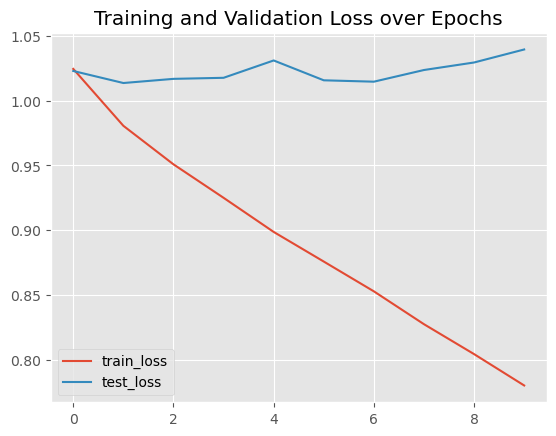

In [45]:
model_lstm.fit(z.train, test=z.test, epochs=10)

In [46]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm], model_names=['lasso', 'lr', 'lstm'])

In [47]:
comp.correl(z, mode='train')

,true,optimal,shift,lasso,lr
optimal,0.2904,nan,nan,nan,nan
shift,0.2904,1.0000,nan,nan,nan
lasso,0.0098,-0.0076,-0.0076,nan,nan
lr,0.0128,-0.0063,-0.0063,0.7664,nan
lstm,0.6005,0.1783,0.1783,0.0021,0.0255


In [48]:
comp.correl(z, mode='test')

,true,optimal,shift,lasso,lr
optimal,0.2883,nan,nan,nan,nan
shift,0.2883,1.0000,nan,nan,nan
lasso,-0.0013,-0.0025,-0.0025,nan,nan
lr,-0.0027,-0.0008,-0.0008,0.7634,nan
lstm,0.0008,0.0139,0.0139,0.0065,0.0103


### Transformer

In [49]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.5):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        encoded = self.encoder(x, src_key_padding_mask=mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [50]:
m = TransformerEncoderModel(100, 10, 10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.51it/s]


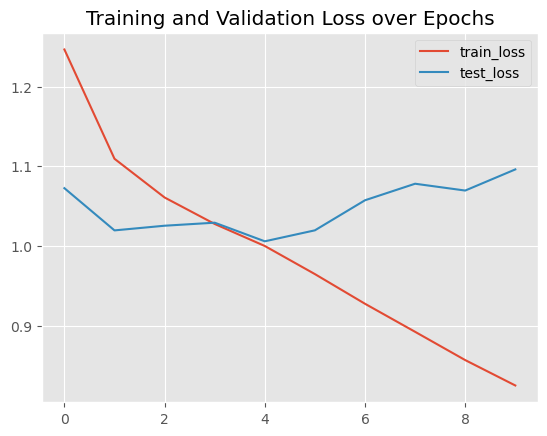

In [51]:
model_torch.fit(z.train, test=z.test, epochs=10)

In [52]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [53]:
comp.correl(z, mode='train')

,true,optimal,shift,lasso,lr,lstm
optimal,0.2904,nan,nan,nan,nan,nan
shift,0.2904,1.0000,nan,nan,nan,nan
lasso,0.0098,-0.0076,-0.0076,nan,nan,nan
lr,0.0128,-0.0063,-0.0063,0.7664,nan,nan
lstm,0.6005,0.1783,0.1783,0.0021,0.0255,nan
transformer,0.5083,0.1494,0.1494,0.0084,0.0106,0.3653


In [54]:
comp.correl(z, mode='test')

,true,optimal,shift,lasso,lr,lstm
optimal,0.2883,nan,nan,nan,nan,nan
shift,0.2883,1.0000,nan,nan,nan,nan
lasso,-0.0013,-0.0025,-0.0025,nan,nan,nan
lr,-0.0027,-0.0008,-0.0008,0.7634,nan,nan
lstm,0.0008,0.0139,0.0139,0.0065,0.0103,nan
transformer,0.0141,0.0179,0.0179,0.0003,-0.0076,0.0987


In [55]:
xb.shape

NameError: name 'xb' is not defined